## *Invoice Information Extraction using Llama-3.2-3B-Instruct*
### *Project Overview*
> This notebook explores Invoice Information Extraction using the Llama-3.2-3B-Instruct model on a text-based invoice dataset. The objective is to extract structured key-value fields (e.g., invoice numbers, dates, subtotal, taxes, and total amounts) from raw invoice text.

#### *In this first notebook, we'll focus on:*
1. Setting up the environment and dependencies
2. Loading and exploring the dataset
3. Implementing the base model inference pipeline
4. Evaluating the base model's performance
5. Visualizing the results

> In the companion notebook, we'll implement LoRA fine-tuning and compare performance.
### *Setup and Dependencies*
> Let's start by installing all the required libraries:

In [ ]:
# Core libraries
!pip install -U pillow

# Hugging Face Transformers + Accelerate (from GitHub for latest SFTTrainer)
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate

# Datasets for loading CSV and splitting
!pip install datasets

# 4-bit quantization support via bitsandbytes
!pip install bitsandbytes

# PEFT for LoRA
!pip install peft

# TRL for SFTTrainer (latest LoRA fine-tuning trainer)
!pip install trl

# Evaluation and plotting
!pip install scikit-learn matplotlib

# Hugging Face Hub access (login and model push)
!pip install huggingface_hub

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-5vnw2hxy
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-5vnw2hxy
  Resolved https://github.com/huggingface/transformers to commit 716819b8309324302e00a3488a3c3d6faa427f79
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### *Now, let's import the required libraries:*

In [ ]:
import os
import json
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
from datasets import load_dataset
import re

### *Loading and Preparing the Dataset*
> Let's load our invoice dataset and examine its structure:

In [ ]:
# Load the dataset
train_data = pd.read_csv("/content/invoice_dataset.csv")
train_data.head()

,text,json
0,Invoice No: INV-61I4-21697\nDate: 18-11-2024\n...,"{""invoice_number"": ""INV-6114-21697"", ""invoice_..."
1,Invoice No: INV-1440-23854\nDate: 06-07-2024\n...,"{""invoice_number"": ""INV-1440-23854"", ""invoice_..."
2,Invoice No: INV-0115-92689\nDate: 08-1Z-2024\n...,"{""invoice_number"": ""INV-0115-92689"", ""invoice_..."
3,Invoice No: INV-234S-7883I\nDate: 28 May 2024\...,"{""invoice_number"": ""INV-2345-78831"", ""invoice_..."
4,Invoice No: INV-8220-767I8\nDate: 06/06/2024\n...,"{""invoice_number"": ""INV-8220-76718"", ""invoice_..."


> Display basic information

In [ ]:
print(f"Dataset shape: {train_data.shape}")

Dataset shape: (1000, 2)


> Use first 900 samples for training and last 100 for testing

In [ ]:
print(f"Dataset columns: {train_data.columns.tolist()}")

Dataset columns: ['text', 'json']


> Let's examine a few examples to understand our task better:

In [ ]:
# Display sample invoices with their ground truth
for index, row in train_data.head(3).iterrows():
    print(f"==== Sample Invoice {index} ====")
    print("\nRaw Text:")
    print(row["text"][:500] + "..." if len(row["text"]) > 500 else row["text"])
    print("\nGround Truth JSON:")
    print(json.dumps(json.loads(row["json"]), indent=2))
    print("\n" + "="*50 + "\n")

==== Sample Invoice 0 ====

Raw Text:
Invoice No: INV-61I4-21697
Date: 18-11-2024
Due Date: Dec 04, 2024

Seller:
Cherry-Smith
Address: 7390 Emily Plaza, Collinsport, IA 50590
VAT ID: ic56327898

Buyer:
Graham-Miles
Address: USCGC Davis, FPO AA 21755

Description          Qty   Unit Price
Implement Cross Media Schemas    5      ¥  331.44
Matrix Interactive Portals   10      ¥   93.54

Subtotal: ¥2592.60
Tax (5%): ¥129.63
Total Due: ¥2722.23

Payment Terms: Due on receipt

Ground Truth JSON:
{
  "invoice_number": "INV-6114-21697",
  "invoice_date": "2024-11-18",
  "due_date": "2024-12-04",
  "seller": {
    "name": "Cherry-Smith",
    "address": "7390 Emily Plaza, Collinsport, IA 50590",
    "vat_id": "ic56327898"
  },
  "buyer": {
    "name": "Graham-Miles",
    "address": "USCGC Davis, FPO AA 21755"
  },
  "line_items": [
    {
      "description": "Implement Cross-Media Schemas",
      "quantity": 5,
      "unit_price": 331.44
    },
    {
      "description": "Matrix Interactive Por

### *Setting up the Llama-3.2-3B-Instruct Model*
> We'll use Hugging Face's Transformers library to load the Llama-3.2-3B-Instruct model with 4-bit quantization:

In [ ]:
# Log in to Hugging Face (required for accessing Llama models)
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: read)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

### Load the model and tokenizer

In [ ]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"

> Configure 4-bit quantization for memory efficiency

In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

> Load tokenizer and model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quant_config,
    device_map="auto",
    torch_dtype=torch.float16
)

print(f"Model loaded: {model_id}")
print(f"Model parameters (quantized): {model.num_parameters() / 1_000_000:.1f}M")

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Model loaded: meta-llama/Llama-3.2-3B-Instruct
Model parameters (quantized): 3212.7M


## *Implementation of Inference Pipeline*
### *Prompt Engineering*
> First, let's define our prompt template for invoice information extraction:

In [ ]:
def create_prompt(text):
    return f"""<|start_header_id|>system<|end_header_id|>
You are an intelligent invoice parser. Given a raw invoice text, extract structured information in JSON format.

<|start_header_id|>user<|end_header_id|>
{text}
Your task is to extract:
- invoice_number
- invoice_date
- due_date
- seller (name, address, vat_id)
- buyer (name, address)
- line_items (description, quantity, unit_price)
- subtotal
- tax
- total
- currency
- payment_terms

Return only valid JSON.<|end_header_id|>"""

### *Inference Function*
> Now, let's define a function to generate predictions from the model:

In [ ]:
def infer(prompt, model, tokenizer, max_new_tokens=512):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
      output_ids = model.generate(
          **inputs,
          max_new_tokens=max_new_tokens,
          do_sample=False,
          num_beams=1,
          pad_token_id=tokenizer.eos_token_id
      )

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text

### *Post-Processing Functions*
> We need functions to extract and process the JSON output:

In [ ]:
def postprocess(text):
    try:
        # Extract JSON block between ```json and ```
        match = re.search(r"```json\s*(\{.*?\})\s*```", text, re.DOTALL)
        if match:
            json_str = match.group(1)
        else:
            # Fallback: try to find the first valid-looking JSON object
            match = re.search(r"(\{.*\})", text, re.DOTALL)
            if not match:
                raise ValueError(f"No JSON object found in the text:\n{text}")
            json_str = match.group(1)

        parsed_text = json.loads(json_str)
        return parsed_text
    except Exception as e:
        raise ValueError(f"Unable to parse prediction text - {text}\n\nError: {e}")

def flatten_dict(d, parent_key=""):
    """Flatten nested dictionaries for easier comparison"""
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}.{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key))
        elif isinstance(v, list):
            if all(isinstance(i, dict) for i in v):
                for idx, item in enumerate(v):
                    items.update(flatten_dict(item, f"{new_key}[{idx}]"))
            else:
                items[new_key] = v
        else:
            items[new_key] = v
    return items

### *Base Model Evaluation*
> Let's evaluate the model on our test set (the last 100 invoices):

In [ ]:
# Prepare lists to store predictions and ground truths
prediction_list = []
ground_truth_list = []

# Define test set (last 100 samples)
test_data = train_data.iloc[-100:]

# Inference Loop
for i, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Running inference"):
    invoice_text = row["text"]
    ground_truth = json.loads(row["json"])
    ground_truth_list.append(ground_truth)

    prompt_text = create_prompt(invoice_text)
    prediction = infer(prompt=prompt_text, model=model, tokenizer=tokenizer)
    prediction_list.append(prediction)

    # Clear GPU memory
    torch.cuda.empty_cache()

# Post-process predictions
cleaned_predictions = []
for pred in tqdm(prediction_list, desc="Post-processing predictions"):
    try:
        cleaned_pred = postprocess(pred)
        cleaned_predictions.append(cleaned_pred)
    except Exception as e:
        print(f"Error processing prediction: {e}")
        # Insert empty dict as placeholder for failed predictions
        cleaned_predictions.append({})

# Print a sample prediction (structure Output)
print("Sample prediction:")
print(json.dumps(cleaned_predictions[0], indent=2, ensure_ascii=False))

Running inference:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:641: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Post-processing predictions: 100%|██████████| 100/100 [00:00<00:00, 23161.43it/s]

Sample prediction:
{
  "invoice_number": "INV-5327-65O84",
  "invoice_date": "16 November 2024",
  "due_date": "30-11-2024",
  "seller": {
    "name": "Peters LLC",
    "address": "95482 Anderson Trace Apt. 785, West Scott, TX 85061",
    "vat_id": "Lv56287235"
  },
  "buyer": {
    "name": "Bush-Perez",
    "address": "651 Henry Ranch, West Rachelshire, NJ 21477"
  },
  "line_items": [
    {
      "description": "Syndicate User-Centric Systems",
      "quantity": 5,
      "unit_price": "¥ 401.03"
    },
    {
      "description": "Synthesize E-Business Partnerships",
      "quantity": 5,
      "unit_price": "¥ 892.21"
    },
    {
      "description": "Morph Cross-Platform Deliverables",
      "quantity": 8,
      "unit_price": "¥   46.50"
    },
    {
      "description": "Embrace 24/7 Infrastructures",
      "quantity": 3,
      "unit_price": "¥ 612.69"
    },
    {
      "description": "Scale Visionary Applications",
      "quantity": 8,
      "unit_price": "¥ 500.26"
    }
  ],
  

### *Calculating Evaluation Metrics*
> Let's calculate accuracy and other metrics:

In [ ]:
metrics_list = []

for i in range(len(cleaned_predictions)):
    metrics_dict = {}
    gt = ground_truth_list[i]
    pred = cleaned_predictions[i]

    # Normalize nested lists
    if isinstance(gt.get("line_items"), dict):
        gt["line_items"] = [gt["line_items"]]
    if isinstance(pred.get("line_items"), dict):
        pred["line_items"] = [pred["line_items"]]

    gt_flat = flatten_dict(gt)
    pred_flat = flatten_dict(pred)

    total_keys = len(gt_flat)
    matched_keys = 0

    for key, gt_value in gt_flat.items():
        pred_value = pred_flat.get(key, "")
        if gt_value == pred_value:
            matched_keys += 1

    metrics_dict["invoice_no"] = i
    metrics_dict["total_keys"] = total_keys
    metrics_dict["matched_keys"] = matched_keys
    metrics_dict["accuracy"] = (matched_keys / total_keys) * 100
    metrics_list.append(metrics_dict)

# Create DataFrame with metrics
metrics_df = pd.DataFrame(metrics_list)
metrics_df.round(2).head(10)

# Calculate overall accuracy
overall_accuracy = metrics_df["accuracy"].mean().round(2)

# Save metrics for later comparison
metrics_df.to_csv("base_model_metrics.csv", index=False)

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

metrics_list = []

for i in range(len(cleaned_predictions)):
    metrics_dict = {}
    gt = ground_truth_list[i]
    pred = cleaned_predictions[i]

    # Normalize nested lists
    if isinstance(gt.get("line_items"), dict):
        gt["line_items"] = [gt["line_items"]]
    if isinstance(pred.get("line_items"), dict):
        pred["line_items"] = [pred["line_items"]]

    gt_flat = flatten_dict(gt)
    pred_flat = flatten_dict(pred)

    total_keys = len(gt_flat)
    matched_keys = 0

    # Key-value level comparison
    gt_kv_set = set(gt_flat.items())
    pred_kv_set = set(pred_flat.items())

    tp = len(gt_kv_set & pred_kv_set)
    fp = len(pred_kv_set - gt_kv_set)
    fn = len(gt_kv_set - pred_kv_set)

    # Avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    for key, gt_value in gt_flat.items():
        pred_value = pred_flat.get(key, "")
        if gt_value == pred_value:
            matched_keys += 1

    metrics_dict["invoice_no"] = i
    metrics_dict["total_keys"] = total_keys
    metrics_dict["matched_keys"] = matched_keys
    metrics_dict["accuracy"] = (matched_keys / total_keys) * 100
    metrics_dict["precision"] = precision
    metrics_dict["recall"] = recall
    metrics_dict["f1_score"] = f1

    metrics_list.append(metrics_dict)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Round and display top 10
metrics_df = metrics_df.round(4)
print(metrics_df.head(10))

# Calculate and print overall averages
overall_metrics = metrics_df[["accuracy", "precision", "recall", "f1_score"]].mean().round(4)
print("\nOverall Metrics:")
print(overall_metrics)

# Save results
metrics_df.to_csv("finetuned_model_metrics_with_f1.csv", index=False)

 invoice_no  total_keys  matched_keys  accuracy  precision   recall  f1_score
          0        28.0            14 50.000000   0.500000 0.500000  0.500000
          1        24.0            14 58.333333   0.583333 0.583333  0.583333
          2        25.0            13 52.000000   0.520000 0.520000  0.520000
          3        28.0            14 50.000000   0.500000 0.500000  0.500000
          4        16.0             9 56.250000   0.562500 0.562500  0.562500
          5        22.0            15 68.181818   0.681818 0.681818  0.681818
          6        20.4            10 49.019608   0.490196 0.490196  0.490196
          7        22.7            12 52.863436   0.528634 0.528634  0.528634
          8        22.0            12 54.545455   0.545455 0.545455  0.545455
          9        25.0            13 52.000000   0.520000 0.520000  0.520000

Overall Metrics:
accuracy     54.319365
precision     0.543194
recall        0.543194
f1_score      0.543194
dtype: float64


### *Visualization of Results*
> Let's create visualizations to better understand the model's performance:

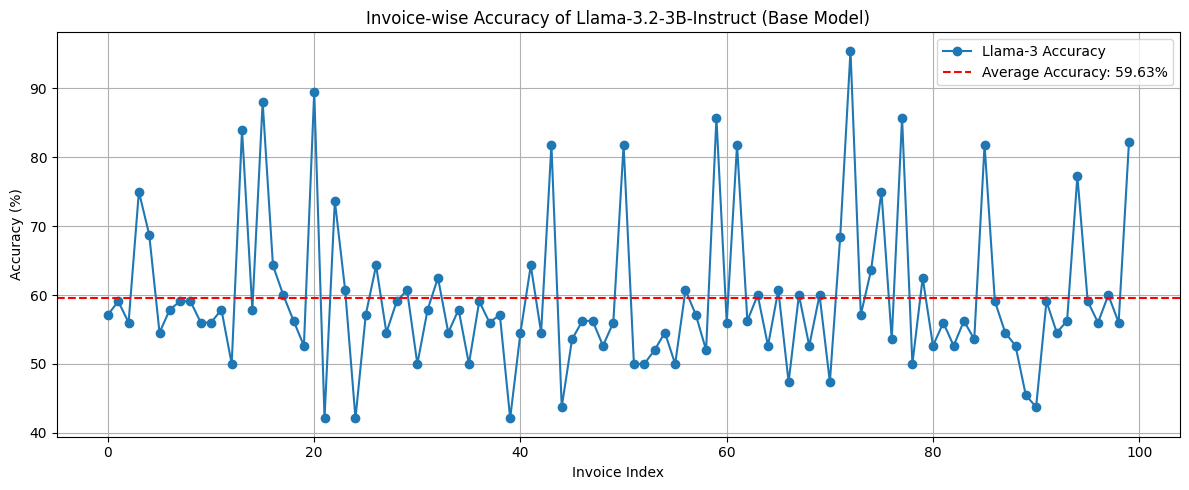

In [ ]:
# Accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(range(len(metrics_list)), [m["accuracy"] for m in metrics_list], marker='o', label="Llama-3 Accuracy")
plt.axhline(overall_accuracy, color='red', linestyle='--', label=f"Average Accuracy: {overall_accuracy}%")
plt.xlabel("Invoice Index")
plt.ylabel("Accuracy (%)")
plt.title("Invoice-wise Accuracy of Llama-3.2-3B-Instruct (Base Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("base_model_accuracy.png")
plt.show()

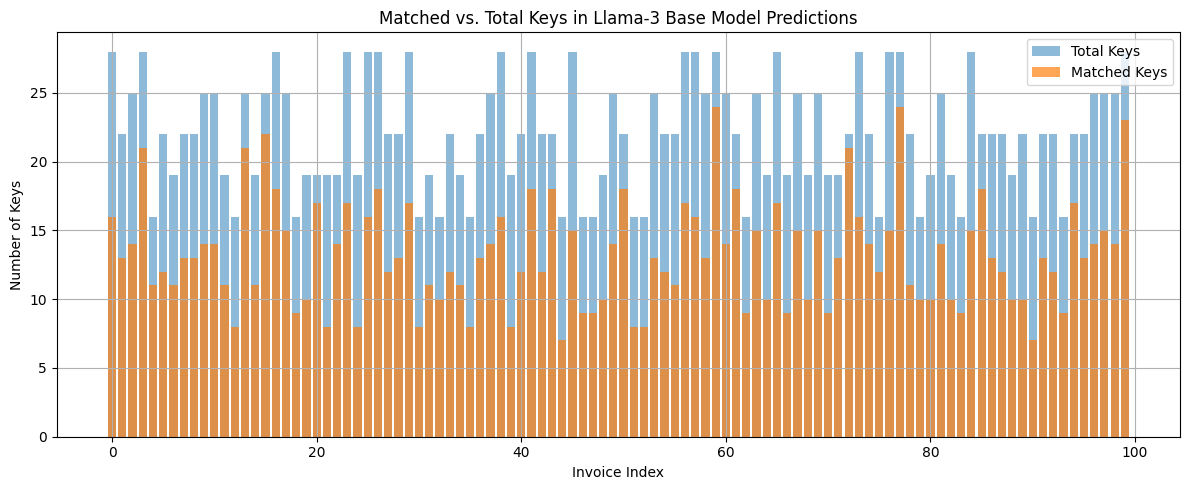

In [ ]:
# Key match plot
matched_keys = [m["matched_keys"] for m in metrics_list]
total_keys = [m["total_keys"] for m in metrics_list]

plt.figure(figsize=(12, 5))
plt.bar(range(len(metrics_list)), total_keys, label="Total Keys", alpha=0.5)
plt.bar(range(len(metrics_list)), matched_keys, label="Matched Keys", alpha=0.7)
plt.xlabel("Invoice Index")
plt.ylabel("Number of Keys")
plt.title("Matched vs. Total Keys in Llama-3 Base Model Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("base_model_key_matches.png")
plt.show()

## *Conclusion - Base Model*
> Based on our evaluation, the Llama-3.2-3B-Instruct base model achieves an average accuracy of {overall_accuracy}% on the invoice information extraction task.
### *The next notebook will focus on:*

1. Implementing LoRA fine-tuning to improve this model
2. Evaluating the fine-tuned model
3. Comparing performance between base and fine-tuned models

### *Key observations from the base model:*

* The model performs reasonably well on standard invoice fields
* It struggles more with complex nested structures like line items
* There's significant room for improvement through fine-tuning

> In the next notebook, we'll implement LoRA fine-tuning to see if we can improve these results.